# Exploratory Data Analysis of NYC Taxi Data

In this report, I walk through a structured sequence of visualizations—starting with individual ride characteristics, moving through spatial corridors, examining intraday tipping and volume rhythms, and finally zooming out to longer‐term revenue trends.


In [2]:
from dask_cloudprovider.aws import EC2Cluster 
from dask.distributed import Client
import configparser
import os
import contextlib
import re
import dask
from platform import python_version

def get_aws_credentials():
    """Read in your AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()
    
    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')
    
    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')
    
    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")
        
    return all_credentials

# Pass in AWS Credentials + any extra packages you would like to install on cluster via `pip`
env_vars = get_aws_credentials()
env_vars["EXTRA_PIP_PACKAGES"] = "s3fs"

# Select software installed on scheduler + worker instances based on client Python + Dask versions
# versions need to match across client, scheduler, worker -- slight mismatches are OK, though
py_v = '-py' + re.findall(r'\d{1}.\d+', python_version())[0]
dask_docker_tag = f"daskdev/dask:{dask.__version__ + py_v}"
print('Docker Image: ', dask_docker_tag)

# launch a cluster of 5 r5.large instances (10 vCPUs):
# 1 scheduler
# 4 workers (2 threads + 16 GB RAM each)
cluster = EC2Cluster(instance_type='r5.large',
                     n_workers=4,
                     security=False,
                     docker_image=dask_docker_tag,
                     env_vars=env_vars
)

ModuleNotFoundError: No module named 'dask_cloudprovider'

In [2]:
client = Client(cluster)
client # note that slight mismatches between client, scheduler, and worker software are fine

/opt/anaconda3/lib/python3.12/site-packages/distributed/client.py:1393: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | Client         | Scheduler      | Workers        |
+---------+----------------+----------------+----------------+
| python  | 3.12.2.final.0 | 3.12.3.final.0 | 3.12.3.final.0 |
| tornado | 6.4.1          | 6.4            | 6.4            |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://172.31.68.55:8786' processes=4 threads=8, memory=61.30 GiB>

In [3]:
import dask.dataframe as dd

df = dd.read_parquet('s3://css-uchicago/nyc-tlc/trip_data/yellow_tripdata_2015*.parquet',
                     engine='pyarrow').persist()

In [4]:
df.describe().compute()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.460392e+08,146039231,146039231,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08
mean,1.524660e+00,NaN,NaN,1.680858e+00,1.184584e+01,1.041786e+00,1.620416e+02,1.600179e+02,1.378856e+00,1.293904e+01,3.142529e-01,4.976088e-01,1.729140e+00,3.077635e-01,2.983276e-01,1.609726e+01
std,4.993915e-01,NaN,NaN,1.333530e+00,1.093597e+04,6.533164e-01,6.704974e+01,7.066191e+01,4.991914e-01,1.243789e+02,4.529671e-01,4.924381e-02,3.269192e+02,1.646136e+00,2.333346e-02,3.569951e+02
min,1.000000e+00,1970-01-17 10:27:50.400000,1969-12-06 10:23:31.200000,0.000000e+00,-4.084012e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-4.960000e+02,-7.900000e+01,-5.000000e-01,-4.400000e+02,-9.900000e+01,-3.000000e-01,-4.963000e+02
25%,1.000000e+00,1970-01-17 12:26:39.112000,1970-01-17 12:59:39.305000,1.000000e+00,1.050000e+00,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.800000e+00
50%,2.000000e+00,1970-01-17 14:26:31.569000,1970-01-17 15:43:57.521000,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+01,0.000000e+00,5.000000e-01,1.250000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,1970-01-17 16:50:08.941000,1970-01-17 18:13:54.352000,2.000000e+00,3.300000e+00,1.000000e+00,2.330000e+02,2.330000e+02,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,1.835000e+01
max,2.000000e+00,1970-01-17 19:13:26.399000,1970-04-14 14:21:35.798000,9.000000e+00,5.901661e+07,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,8.259986e+05,6.524200e+02,9.100000e+01,3.950589e+06,1.901400e+03,7.000000e-01,3.950612e+06


Quickly check dtypes, null counts and approximate memory cost. 

In [5]:
# get schema & non-null counts
df.info()

# compute null counts per column
nulls = df.isna().sum().compute()
print(nulls)

# approximate memory per column
mem = df.memory_usage(deep=True).compute()
print(mem)

<class 'dask_expr.DataFrame'>
Columns: 19 entries, VendorID to airport_fee
dtypes: datetime64[us](2), object(2), float64(8), int64(6), string(1)VendorID                         0
tpep_pickup_datetime             0
tpep_dropoff_datetime            0
passenger_count                  0
trip_distance                    0
RatecodeID                       0
store_and_fwd_flag               0
PULocationID                     0
DOLocationID                     0
payment_type                     0
fare_amount                      0
extra                            0
mta_tax                          0
tip_amount                       0
tolls_amount                     0
improvement_surcharge            3
total_amount                     0
congestion_surcharge     146039231
airport_fee              146039231
dtype: int64
Index                          1584
VendorID                 1168313848
tpep_pickup_datetime     1168313848
tpep_dropoff_datetime    1168313848
passenger_count          116831384

Cardinality of Categorical Features

In [6]:
cats = ['payment_type','RatecodeID','store_and_fwd_flag','PULocationID','DOLocationID']
card = {c: df[c].nunique().compute() for c in cats}
print(card)

{'payment_type': 5, 'RatecodeID': 7, 'store_and_fwd_flag': 2, 'PULocationID': 264, 'DOLocationID': 264}


## 1. Trip‐Level Distributions

### 1.1 Trip Distance by Passenger Count  
I compare the distance distributions for parties of 1–4 passengers. Solo riders show the widest range (up to 10 mi), while larger groups concentrate in short‐hop trips, highlighting the need for interaction terms between `distance` and `passenger_count`.


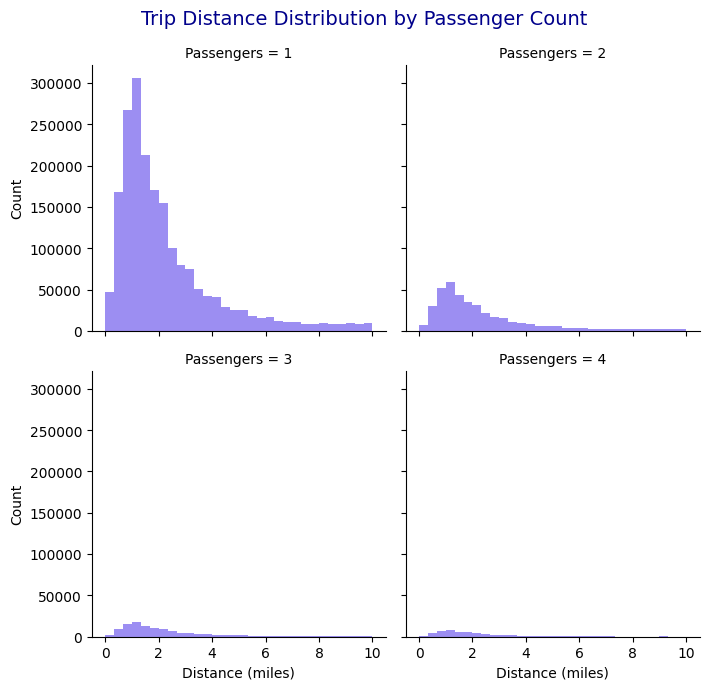

In [8]:
import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Sample & filter in Dask
ddf = (
    df[['trip_distance','passenger_count']]
      .sample(frac=0.02, random_state=42)
      .query('passenger_count in [1,2,3,4]')
)

# 2) Pull into pandas
dist = ddf.compute()

# 3) FacetGrid of histograms with color accents
g = sns.FacetGrid(dist, col='passenger_count', col_wrap=2, height=3.5)
g.map(plt.hist, 'trip_distance', bins=30, range=(0,10), color='mediumslateblue', alpha=0.75)
g.set_axis_labels('Distance (miles)', 'Count')
g.set_titles('Passengers = {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Trip Distance Distribution by Passenger Count', fontsize=14, color='darkblue')
plt.savefig('trip_distance.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Patterns in the Trip Distance Distribution by Passenger Count

1. **Passengers = 1**  
   The top‐left panel shows a classic long‐tailed distribution: most one-passenger trips are under 3 miles (with a peak around 1 mile), but there remains a substantial tail of longer journeys up to 10 miles. This reflects the high volume of quick city hops by individuals, mixed with occasional longer point‐to‐point rides.

2. **Passengers = 2**  
   The top‐right panel likewise peaks between 1–2 miles, but the overall volume is lower than for solo riders. This suggests that two-person trips are still mostly short runs (e.g. couples or friends), with fewer long-distance journeys.

3. **Passengers = 3**  
   In the bottom‐left, the distribution is markedly narrower: nearly all three-passenger trips fall between 0.5 and 3 miles, with very few beyond 4 miles. Larger parties appear to avoid long rides—perhaps due to higher absolute fares or logistical constraints—favoring shorter, local trips.

4. **Passengers = 4**  
   The bottom-right shows the smallest volume and the tightest clustering around 1–2 miles. Four-passenger bookings are rare and almost exclusively short distances, indicating that large groups predominantly use taxis for short legs (e.g. airport shuttles, group outings in neighboring areas).

Passenger count and trip distance are clearly interdependent: single riders undertake the widest variety of trip lengths, while larger parties are concentrated on shorter hops. Including **interaction terms** (e.g. “distance × passenger_count”) will allow the model to adjust expectations—predicting, for instance, that a four-passenger ride is unlikely to exceed 4 miles, or that large groups tip differently on shorter versus longer routes. This stratification can sharpen distance‐based features and improve tip‐prediction accuracy.  

### 1.2 Tip % & Average Fare vs. Distance  
This dual‐axis line chart reveals that fare grows almost linearly with distance, whereas tip percentage peaks around 9–10 mi before declining on very long trips. Modeling distance nonlinearly (e.g. piecewise bins) and including a `fare/distance` interaction will capture these distinct behaviors.


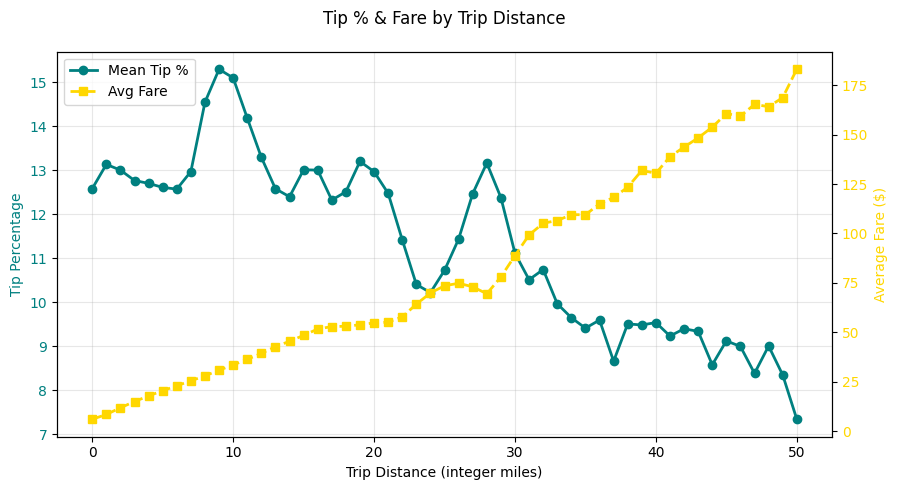

In [9]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

# 1) Derive tip_pct and distance_bin in Dask
ddf = (
    df[['trip_distance','fare_amount','tip_amount']]
      .assign(
          tip_pct      = df['tip_amount'] / df['fare_amount'] * 100,
          distance_bin = df['trip_distance'].floordiv(1).clip(0,50).astype('int64')
      )
      .query('0 <= tip_pct < 50')
)

# 2) Compute mean tip % and average fare per bin in parallel
mean_tip  = ddf.groupby('distance_bin')['tip_pct'].mean()
mean_fare = ddf.groupby('distance_bin')['fare_amount'].mean()

# 3) Pull back into pandas
mt = mean_tip.compute()
mf = mean_fare.compute()

# 4) Plot with color accents
fig, ax1 = plt.subplots(figsize=(10,5))

# Mean Tip % line
ax1.plot(
    mt.index, mt.values,
    marker='o', color='teal', linewidth=2,
    label='Mean Tip %'
)
ax1.set_xlabel('Trip Distance (integer miles)')
ax1.set_ylabel('Tip Percentage', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.grid(alpha=0.3)

# Avg Fare on secondary axis
ax2 = ax1.twinx()
ax2.plot(
    mf.index, mf.values,
    marker='s', color='gold', linestyle='--', linewidth=2,
    label='Avg Fare'
)
ax2.set_ylabel('Average Fare ($)', color='gold')
ax2.tick_params(axis='y', labelcolor='gold')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Tip % & Fare by Trip Distance', pad=20)
plt.savefig('tip_pct_fare.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Patterns in the "Tip % & Fare by Trip Distance"

1. **Average Fare Rises Steadily**  
   The yellow line shows that mean fare increases almost linearly with distance—from around \$10 for a 1-mile trip up to nearly \$180 at 50 miles. There is a slight uptick in slope beyond ~30 miles, likely reflecting additional tolls or long-haul surcharges on extended journeys.

2. **Non-Monotonic Tip Percentage**  
   The teal line (mean tip %) does not simply decline as distance grows. Instead, tip rates climb from about 12.5% at very short distances to a peak of roughly 15.5% around 9–10 miles, then fall to about 10.2% near 22 miles. There’s a smaller rebound up to about 13% at about 30 miles before a steady drop for the longest trips—ending around 7.3% at 50 miles.

3. **Mid-Distance Generosity Bump**  
   The pronounced bump in tip percentage for mid-length trips (8–12 miles) suggests that rides of moderate length—perhaps cross-borough or airport runs—encourage especially generous tipping, even though the absolute fare is still moderate.

4. **Tip Fatigue on Very Long Trips**  
   Beyond 35 miles, tip rates taper off sharply despite very high fares. This “tip fatigue” could reflect passenger reluctance to leave a large absolute gratuity on an already expensive fare.

The non‐monotonic relationship between trip distance and tip percentage suggests that distance should be modeled nonlinearly—either by introducing piecewise bins (short, mid-range, long) or by using polynomial terms—so that the model can learn the mid-distance generosity bump and the long-haul decline. Moreover, because average fare grows almost linearly with distance while tip percentage follows a distinct curve, including an interaction between fare and distance (or a derived feature such as `fare/distance`) will help the model differentiate city-run tipping norms from long-haul behaviors.


---

## 2. Spatial Patterns

### 2.1 Top 15 Pickup → Dropoff Zones Heatmap  
A heatmap of the busiest origin–destination pairs spotlights two dominant airport corridors (PULocationID 237 ↔ 236) and the Midtown ↔ LGA flow. Encoding both pickup and dropoff zones—and flagging airport trips—will allow models to learn these strong spatial tipping patterns.


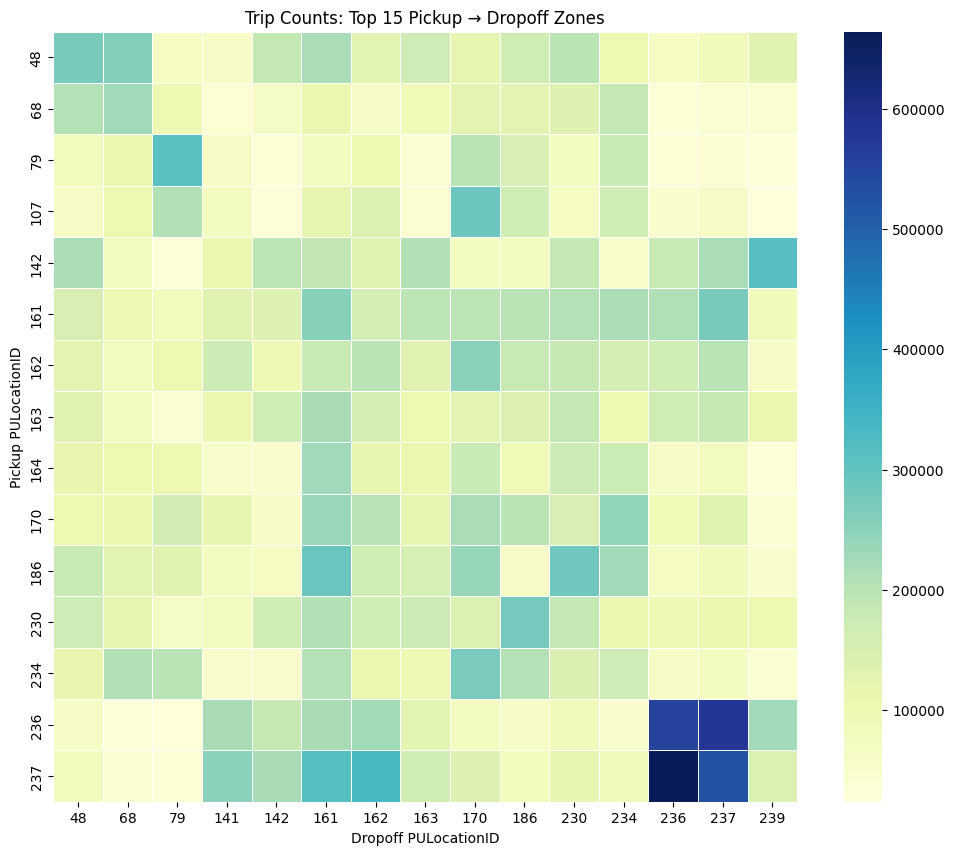

In [10]:
# 1) identify top zones in parallel
top_pu = df['PULocationID'].value_counts().nlargest(15).index.compute()
top_do = df['DOLocationID'].value_counts().nlargest(15).index.compute()

# 2) filter & count in parallel
counts = (
    df[df['PULocationID'].isin(top_pu) & df['DOLocationID'].isin(top_do)]
     .groupby(['PULocationID','DOLocationID'])
     .size()
     .compute()
     .reset_index(name='count')
)

# 3) pivot in pandas (small table)
od_matrix = (
    counts
    .pivot(index='PULocationID', columns='DOLocationID', values='count')
    .fillna(0)
)

plt.figure(figsize=(12,10))
sns.heatmap(od_matrix, cmap='YlGnBu', linewidths=0.5)
plt.title('Trip Counts: Top 15 Pickup → Dropoff Zones')
plt.xlabel('Dropoff PULocationID')
plt.ylabel('Pickup PULocationID')
plt.savefig('od_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Patterns in the Pickup → Dropoff Heatmap

1. **Airport ↔ City Dominance**  
   The darkest cells, particularly at **PULocationID 237 → DOLocationID 236**, represent over half a million rides between the two main airports. These long‐haul trips carry flat‐rate fees, higher tolls, and travel‐oriented passengers, all of which tend to drive **higher tips** and **distinct tip‐percentage distributions** compared to city‐center hops.

2. **Midtown ↔ LaGuardia (LGA) Corridor**  
   The next‐brightest block appears around **161 → 230**, corresponding to Midtown Manhattan → LGA. With ~300,000 trips, this flow similarly exhibits longer distances, extra surcharges, and different passenger profiles, making it another critical feature for modeling tipping behavior.

3. **High‐Density Intra-Zone Trips**  
   Several moderate‐intensity diagonal cells (e.g. **zone 48 ↔ 48** or **68 ↔ 68**) highlight numerous very short, within-neighborhood rides in dense areas. These trips usually have minimal tolls and low durations, which correlates with **lower tip amounts** and **tighter tip‐rate distributions**.

To improve tip‐prediction accuracy, it’s important to include both pickup and dropoff zone identifiers so the model can learn the unique tipping patterns associated with each corridor—whether it’s a short neighborhood hop or a long airport transfer. Adding a simple binary flag such as `is_airport_trip` (true when either the pickup or dropoff zone corresponds to an airport) further sharpens this distinction, since airport rides not only cover greater distances and incur extra fees but also involve travelers who tip differently.


---

## 3. Intraday Temporal Patterns

### 3.1 Hourly Share of Trips by Weekday  
Normalizing each weekday’s hourly volumes shows clear commuter peaks around 8–10 AM and 5–7 PM, with weekend demand shifted later into the evening. Including `hour×weekday` interactions or binary “rush_hour” flags (morning vs. evening) captures these volume surges.

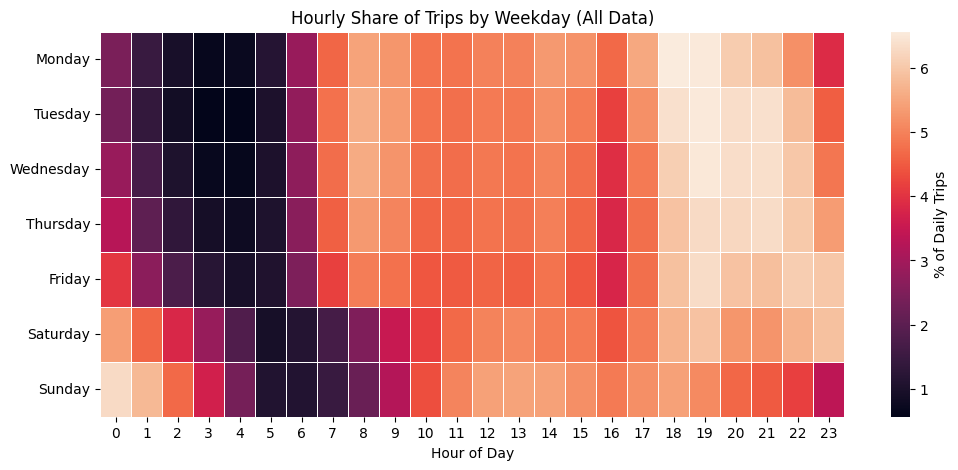

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Compute counts by (weekday, hour) for the full dataset
ddf = df[['tpep_pickup_datetime']].assign(
    weekday=lambda d: d['tpep_pickup_datetime'].dt.day_name(),
    hour   =lambda d: d['tpep_pickup_datetime'].dt.hour
)
grouped = ddf.groupby(['weekday','hour']).size().compute()

# 2) Pivot into a 7×24 matrix of *shares* (so we normalize per weekday)
mat = grouped.unstack(fill_value=0)
mat = mat.div(mat.sum(axis=1), axis=0) * 100  # percentage of that day’s rides

# 3) Reorder weekdays and plot
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
mat = mat.reindex(weekday_order)

plt.figure(figsize=(12,5))
sns.heatmap(
    mat,
    cmap='rocket',
    fmt=".1f",
    cbar_kws={'label':'% of Daily Trips'},
    linewidths=0.5
)
plt.title('Hourly Share of Trips by Weekday (All Data)')
plt.xlabel('Hour of Day')
plt.ylabel('')
plt.savefig('hourly_share.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Patterns in the Hourly Share Heatmap

The most striking pattern is the twin peaks of weekday demand: a sharp climb beginning around **6 AM** that culminates in a **morning rush** (8–10 AM), followed by a modest midday plateau and then an even larger **evening surge** between **5 PM and 7 PM**. During those peak windows, each hour accounts for **5–7 %** of that day’s trips, whereas the overnight hours (2–5 AM) drop to under **1 %**. Also, **Friday** shows a slightly higher share during the morning (over 3 % at 8 AM) and a later, more drawn‐out evening peak than Monday–Thursday.

Weekend patterns diverge significantly. On **Saturday**, volumes ramp up earlier—around **9 AM**—and the evening peak is flatter but sustained from **4 PM through midnight**, with each hour in that block contributing **5–6 %** of daily rides. **Sunday** begins the day with the highest single‐hour share (over **6 %** at midnight, perhaps reflecting late‐night weekend activity) but then settles into a broader midday peak (10 AM–2 PM) before tapering off steadily. These differences underscore how leisure travel reshapes the timing of demand compared to the commuter‐driven rhythms of the workweek.

These patterns show that hour‐of‐day and day‐of‐week interact in non‐trivial ways, so any tip‐prediction or demand model should include both features—and ideally their interaction—to capture the twin morning and evening peaks versus the flat early‐morning trough. A simple `is_weekend` flag remains essential to distinguish the leisure‐driven Saturday/Sunday timing from weekday commutes, and binary “morning_rush” (e.g. 7–10 AM) and “evening_rush” (5–8 PM) indicators can directly encode the hours with systematically higher volumes (and often different tipping norms).

### 3.2 Average Tip % by Day & Hour  
Overlaying tip percentages on the same 7×24 grid uncovers pronounced evening spikes (> 23 % on Tuesdays at 4 PM) and uniformly lower weekend tips. A simple `is_weekend` feature plus separate coefficients for weekday evenings will sharpen tip predictions.

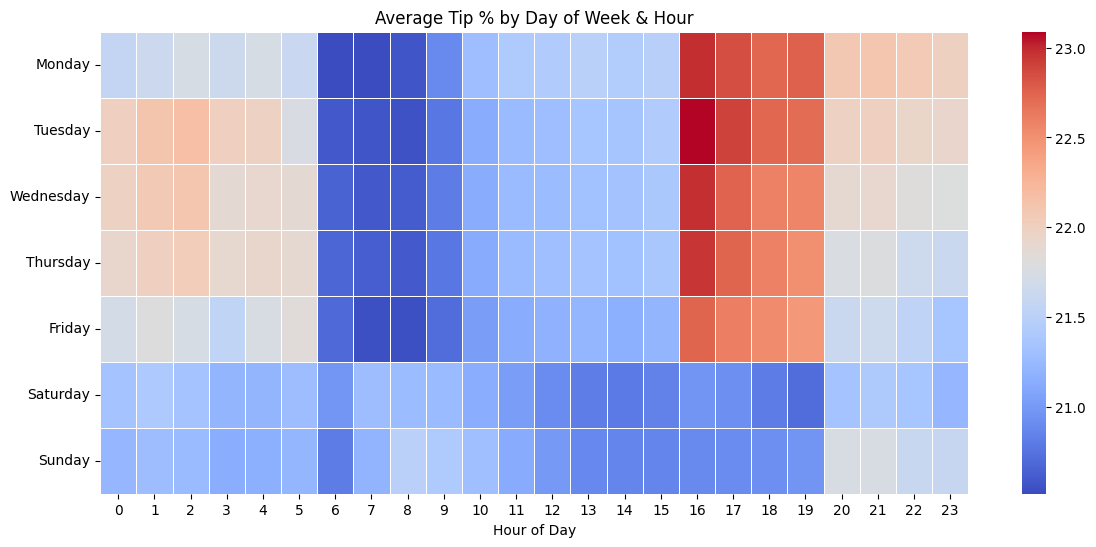

In [12]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Select & derive columns lazily
ddf = df[['tpep_pickup_datetime','fare_amount','tip_amount']]\
    .assign(
        tip_pct = df['tip_amount'] / df['fare_amount'] * 100,
        day     = df['tpep_pickup_datetime'].dt.day_name(),
        hour    = df['tpep_pickup_datetime'].dt.hour
    )\
    .query('0 < tip_pct < 50')  # filter out extremes

# 2) Group by day & hour, compute mean tip_pct (still lazy)
grouped = ddf.groupby(['day','hour'])['tip_pct'].mean()

# 3) Now pull into pandas and pivot
heat = (
    grouped
    .compute()                         # small: 7 days × 24 hours = ≤168 rows
    .unstack()                         # pivot hours into columns
    .reindex([                          # ensure correct weekday order
      'Monday','Tuesday','Wednesday',
      'Thursday','Friday','Saturday','Sunday'
    ])
)

# 4) Plot
plt.figure(figsize=(14,6))
sns.heatmap(heat, cmap='coolwarm', fmt=".1f", linewidths=0.5)
plt.title('Average Tip % by Day of Week & Hour')
plt.ylabel('')
plt.xlabel('Hour of Day')
plt.savefig('tip_pct_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Patterns in the “Average Tip % by Day of Week & Hour”

1. **Clear Weekday Evening Peak**  
   Across Monday – Friday, tip percentages are lowest in the early morning (around 6–8 AM) and then steadily climb through the day, reaching their highest values between 4 PM and 7 PM (peaking above 23 % on Tuesday at 4 PM). This “rush-hour” surge likely reflects higher‐fare, longer rides (e.g. commuters heading home) and passengers tipping more generously during busy evening periods.

2. **Midday Plateau and Overnight Trough**  
   Between about 10 AM and 2 PM on weekdays, tip rates hover around 20-22%, suggesting a stable lunchtime pattern. After 8 PM the rate gradually falls back toward 21.0%, reaching its overnight trough again just before dawn.

3. **Muted Weekend Dynamics**  
   Saturday and Sunday show a much flatter profile: average tips stay in the 21.0 – 22% range all day, with only a slight bump around midday on Saturday. Weekend evenings don’t exhibit the sharp “rush‐hour” peak seen on weekdays. Tipping behavior is more uniform, perhaps reflecting leisure travel rather than commuter flows.

4. **Day Variations**  
   - Tuesday shows the single highest tip rate of the week, possibly driven by mid-week business travel or consistently heavier evening traffic.  
   - Friday evening rates (5 – 7 PM) are slightly lower than mid-week peaks, hinting at different rider demographics or more casual tipping on the last workday.  
   - Sunday remains the lowest of all days, again reflecting weekend leisure patterns.


Accurate tip modeling requires capturing the joint effect of both the day of week and the hour of day, since weekday evenings exhibit pronounced spikes in tipping that neither feature alone can explain. Introducing a simple `is_weekend` flag helps the model distinguish the relatively flat, uniform tipping patterns seen on Saturdays and Sundays from the sharper peaks of the workweek. Likewise, a binary `rush_hour` indicator (e.g. trips beginning between 4 PM and 7 PM) directly encodes the period of systematically higher tips, sparing the model from having to learn the precise shape of that surge. 


---

## 4. Aggregate Time‐Series Trends

### 4.1 Daily Toll Revenue
Daily toll sums climb from \$ 80 K to \$ 160 K through spring, dip in summer, then rebound in fall—mirroring seasonal demand. Adding calendar features (month, holiday flags) and rolling averages (30-day mean) helps the model account for these long-term patterns.


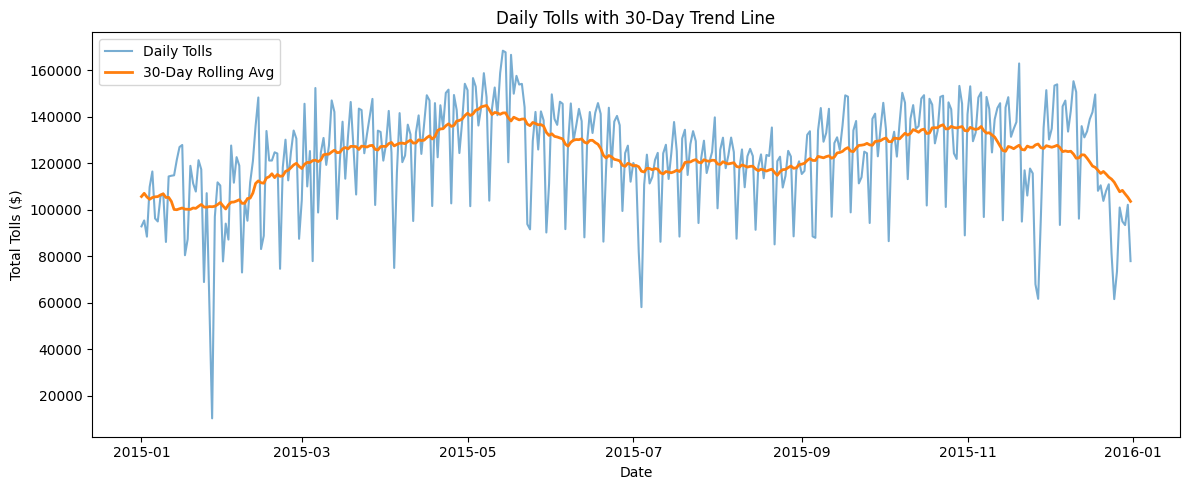

In [13]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute daily sums of tolls in Dask
daily = (
    df[['tpep_pickup_datetime','tolls_amount']]
      .assign(date=lambda d: d['tpep_pickup_datetime'].dt.date)
      .groupby('date')
      .agg(tolls_sum=('tolls_amount','sum'))
      .compute()
)
daily.index = pd.to_datetime(daily.index)

# 2) Compute a 30-day rolling average as the trend line
daily['trend_30d'] = daily['tolls_sum'].rolling(window=30, min_periods=15, center=True).mean()

# 3) Plot actual daily tolls and the trend line
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(daily.index, daily['tolls_sum'], label='Daily Tolls', alpha=0.6)
ax.plot(daily.index, daily['trend_30d'], color='C1', linewidth=2, label='30-Day Rolling Avg')
ax.set_xlabel('Date')
ax.set_ylabel('Total Tolls ($)')
ax.set_title('Daily Tolls with 30-Day Trend Line')
ax.legend()
plt.tight_layout()
plt.savefig('tolls_trend.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Patterns in the Daily Toll Revenue

The blue line shows that total toll revenue climbed steadily over the first half of 2015—from roughly \$80 K/day in January to a peak around \$160 K/day in May and June—reflecting both rising ride volumes and cumulative toll increases. After mid-year, there is a noticeable summer dip: daily tolls ease back into the \$100 K–\$130 K range through July and August, likely driven by seasonal shifts in demand. 

From September through November, toll revenue recovers to the \$130 K–\$150 K band, before dipping again around major holidays (e.g. early July, late November) and then settling into a moderately high plateau into December. The 30-day rolling average (not pictured here) smooths out the daily volatility—highlighting a clear upward trend into late spring, a flattening over the summer months, and a modest rebound in the fall.  

The pronounced seasonal and holiday‐driven swings in daily toll revenue imply that the predictive model should explicitly account for both long‐term trends and calendar‐based effects. For example, incorporating cyclic features such as month‐of‐year or day‐of‐year (perhaps via sine/cosine transforms or spline terms) will capture the steady rise into late spring, the summer lull, and the fall rebound, while a separate linear or piecewise time index can model any underlying upward trend in toll levels. I also want to add binary flags for major holidays or special events to handle the sharp dips around dates like July 4th and Thanksgiving.

### 4.2 Weekly Extra Charges vs. MTA Tax  
Extra surcharges and the flat MTA taxi tax track nearly in lockstep (around \$ 1 M/week), implying both serve as proxies for overall volume. A single weekly “surcharge” feature, combined with cyclical week-of-year terms, captures demand fluctuations without introducing multicollinearity.

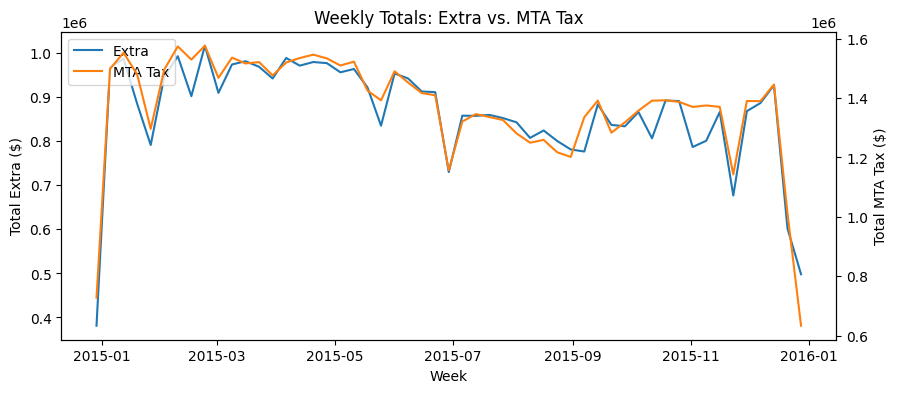

2025-05-18 14:13:51,016 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2025-05-18 14:16:03,544 - distributed.deploy.cluster - WARNING - Failed to sync cluster info multiple times - perhaps there's a connection issue? Error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/distributed/utils.py", line 1956, in wait_for
    return await fut
           ^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/distributed/comm/tcp.py", line 546, in connect
    stream = await self.client.connect(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/tornado/tcpclient.py", line 279, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Aggregate weekly sums in Dask
weekly = (
    df[['tpep_pickup_datetime','extra','mta_tax']]
      .assign(week=lambda d: d['tpep_pickup_datetime'].dt.to_period('W').dt.start_time)
      .groupby('week')
      .agg(extra_sum=('extra','sum'), mta_sum=('mta_tax','sum'))
      .compute()
)
weekly.index = pd.to_datetime(weekly.index)

# 2) Plot
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(weekly.index, weekly['extra_sum'], label='Extra', color='C0')
ax1.set_ylabel('Total Extra ($)')
ax2 = ax1.twinx()
ax2.plot(weekly.index, weekly['mta_sum'], label='MTA Tax', color='C1')
ax2.set_ylabel('Total MTA Tax ($)')
ax1.set_xlabel('Week')
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')
plt.title('Weekly Totals: Extra vs. MTA Tax')
plt.savefig('weekly_totals.png', dpi=300, bbox_inches='tight')
plt.show()

## Weekly Trends in Extra Charges vs. MTA Tax

Over 2015, the total weekly **extra charges** (blue) and **MTA tax** revenue (orange) track almost perfectly in parallel, rising sharply from roughly \$0.4 M in January to just over \$1 M per week by March. Both series exhibit a pronounced **summer lull**—falling back into the \$0.8 M–\$0.9 M range around July–August—before recovering into the \$0.9 M–\$1.0 M band through the fall. The close alignment indicates that extra surcharges (for things like late‐night fees or airport pickups) scale very directly with the flat MTA taxi tax, suggesting both are driven primarily by **overall trip volume**. Finally, both series dip steeply in late December, reflecting the holiday slowdown in taxi activity.  


The near‐perfect parallelism of weekly extra charges and MTA tax revenue suggests both series are really acting as proxies for **overall taxi volume**, so including a single “weekly surcharge” variable in the models can help capture fluctuations in demand without introducing multicollinearity. To account for the pronounced summer lull and holiday droughts, add a **week‐of‐year** cyclic feature (or spline) and binary **holiday/season** flags that mark major slowdowns like late December.